In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.io import loadmat, savemat
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from scipy.sparse import csc_matrix, csr_matrix

np.set_printoptions(precision=15, linewidth=1000)

In [2]:
target_save, prepared_save = {}, {}
for num in range(1, 6):
    for D in [5, 6, 7, 8, 9]:
        sub = [i for i in sorted(os.listdir('./data_322')) if f'num{num}' in i][0]
        path = f'./data_322/{sub}'
        s = File(f'{path}/target_state/322_violation_d3_D{D}_{sub}_target_state_vector.mat')
        target_state = s['target_state_vec_40'][:].view('complex')
        s.close()

        load = loadmat(f'{path}/fidelity_state_pr_violation_num{num}.mat')
        fidelity = [load[f'D{D}_vec40_r{r}_fidelity'][0][0] for r in range(1, 6)]
        max_ind = np.argmax(fidelity) + 1  # r is from 1 to 5
        prepared_state = load[f'D{D}_vec40_r{max_ind}_state'][0]
        prepared_state = symmetric_decoding(prepared_state, n_qudits=7)

        target_save[f'num{num}_D{D}_vec40'] = target_state
        prepared_save[f'num{num}_D{D}_vec40'] = prepared_state
# savemat('./data_322/target_state_violation.mat', target_save)
# savemat('./data_322/prepared_state_violation.mat', prepared_save)
target_save, prepared_save

({'num1_D5_vec40': array([ 7.517790445026453e-11+3.013375254374548e-11j,  9.449965302594912e-11-6.466182017464099e-11j, -7.512239342122617e-11-3.013641628000916e-11j, ...,  0.000000000000000e+00+0.000000000000000e+00j,  0.000000000000000e+00+0.000000000000000e+00j,  0.000000000000000e+00+0.000000000000000e+00j]),
  'num1_D6_vec40': array([-9.096394850506181e-12+5.870224213194541e-15j, -1.285853576886310e-11+1.317913675842137e-13j, -6.372045948934316e-12+6.481657074522340e-12j, ..., -0.000000000000000e+00+0.000000000000000e+00j, -0.000000000000000e+00+0.000000000000000e+00j, -0.000000000000000e+00+0.000000000000000e+00j]),
  'num1_D7_vec40': array([-2.881936728451162e-12-5.388257559296077e-13j,  1.889951726658485e-12-3.691146856849957e-12j, -2.830365317537961e-12-7.587020366905510e-13j, ...,  0.000000000000000e+00+0.000000000000000e+00j,  0.000000000000000e+00+0.000000000000000e+00j,  0.000000000000000e+00+0.000000000000000e+00j]),
  'num1_D8_vec40': array([-6.304581836037344e-11+2.0644

In [2]:
fidelity = {}
for num in range(1, 6):
    sub = [i for i in sorted(os.listdir('./data_322')) if f'num{num}' in i][0]
    path = f'./data_322/{sub}'
    try:
        load = loadmat(f'{path}/fidelity_state_pr_violation_num{num}.mat')
        for D in [5, 6, 7, 8, 9]:
            num_D = f'num{num}_D{D}'
            fidelity[num_D] = np.array([v[0][0] for k, v in load.items() if f'D{D}' in k and 'fidelity' in k])
    except FileNotFoundError:
        load = {}
fidelity

{'num1_D5': array([0.999999092425634, 0.999999967396896, 0.999999284877047, 0.999629223037849, 0.999999562104968]),
 'num1_D6': array([0.999999853915765, 0.999999971058644, 0.999999706634812, 0.999994525212342, 0.999999084047456]),
 'num1_D7': array([0.999999188227732, 0.999999851477737, 0.999997000133483, 0.999999557101236, 0.999999026522386]),
 'num1_D8': array([0.999999053733476, 0.999999998659182, 0.999999620863459, 0.999997562939185, 0.993363168982594]),
 'num1_D9': array([0.999935455070794, 0.999999461512993, 0.999997604424448, 0.999999098813856, 0.999998091577581]),
 'num2_D5': array([0.999999940941629, 0.999999998494036, 0.999999913275412, 0.999999785189011, 0.999999916853705]),
 'num2_D6': array([0.99999996329828 , 0.999999018375263, 0.999998905706431, 0.999999814840409, 0.99999990652342 ]),
 'num2_D7': array([0.999999506337642, 0.999999808318599, 0.999999896773363, 0.999999960030541, 0.999999708944272]),
 'num2_D8': array([0.999995756864802, 0.999998679896959, 0.9999982331517

In [2]:
path = f'./data_322/beforeL'
fidelity = {}
for num in range(1, 6):
    num_str = f'num{num}'
    try:
        load = loadmat(f'{path}/fidelity_state_pr_beforeL_{num_str}.mat')
    except FileNotFoundError:
        load = {}
    fidelity[num_str] = np.array([])
    for num_iter in range(1, 7):
        iter_str = f'iter{num_iter}'
        v_list = [v[0][0] for k, v in load.items() if iter_str in k and 'fidelity' in k]
        if v_list:
            v_mean = np.mean(sorted(v_list, reverse=True)[:5])
            fidelity[num_str] = np.append(fidelity[num_str], v_mean)
fidelity

{'num1': array([0.999269822533699, 0.999234713241158, 0.999317771458335, 0.999286081243636, 0.999423455892561, 0.99950396394006 ]),
 'num2': array([0.997897302539924, 0.997714191715225, 0.998485571897032, 0.998889492736053, 0.999085616829925, 0.999281194299211]),
 'num3': array([0.99862443576283 , 0.998778579022339, 0.998982834264827, 0.998973811481138, 0.999177740150381, 0.999216838916707]),
 'num4': array([0.999289132246952, 0.999437253891506, 0.999382329480921, 0.999550811572189, 0.999522646270266, 0.999456554039193]),
 'num5': array([0.999902109619392, 0.999941346330573, 0.999963009372423, 0.999986049665958, 0.999994059517396, 0.999995245721214])}

In [ ]:
# rename model folder
for sub in sorted(os.listdir('./')):
    if 'data' in sub:
        new = re.sub('data_d3_D\d+_ergodic_', '', sub)
        os.rename(f'./{sub}', f'./{new}')

# move target_state
for sub in sorted(os.listdir('./')):
    if 'state' in sub:
        new = re.search('num\d+_model\d+', sub).group(0)
        os.renames(f'./{sub}', f'./{new}/target_state/{sub}')

# move RDM & uMPS
for num in range(1, 6):
    path = f'./{sorted(os.listdir("./"))[num]}'
    for name in os.listdir(path):
        if 'RDM_' in name:
            os.renames(f'{path}/{name}', f'{path}/RDM/{name}')
        if 'uMPS_' in name:
            os.renames(f'{path}/{name}', f'{path}/uMPS/{name}')

In [2]:
def file_dict(path):
    file_dict = {}
    for root, dirs, files in os.walk(path):
        i = 1
        for name in sorted(files):
            subfolder = os.path.split(root)[-1]
            file_dict[f'{subfolder}_{i}'] = name
            i += 1
    return file_dict, i


folder_dict = {
    1: 'type1_no_violation',
    2: 'type2_Q3_Q4_different_violation',
    3: 'type3_Q3_Q4_same_violation',
    4: 'type4_Q4_violation'
}
path = f'./data_232/{folder_dict[1]}'
mat_dict, n = file_dict(path)

for num in range(1, n):
    RDM_name = mat_dict[f'RDM_{num}']
    model = re.search('model\d+', RDM_name).group(0)

    rdm2 = loadmat(f'{path}/RDM/{RDM_name}')['RDM_2']
    s = File(f'{path}/target_state/{mat_dict[f"target_state_{num}"]}')
    state = s['target_state_vec'][:].view('complex').conj()  # bra -> ket
    s.close()

    rho = np.outer(state, state.conj())
    print(f'num{num}, {model}, Rank:', matrix_rank(rdm2))
    entropy = -np.trace(rdm2 @ logm(rdm2)).real
    print('Entropy: %.20f' % entropy)

num1, model0, Rank: 9
Entropy: 1.36966680149602848537
num2, model281, Rank: 4
Entropy: 0.69314718065450431350
num3, model283, Rank: 8
Entropy: 1.09861228871317040401
num4, model313, Rank: 4
Entropy: 0.69314718074118897295
num5, model358, Rank: 3
Entropy: 0.00000000000332230604
num6, model375, Rank: 8
Entropy: 1.09861228880950156928
num7, model384, Rank: 5
Entropy: 0.00000000055060529069
num8, model479, Rank: 8
Entropy: 1.09861229505282964602
num9, model530, Rank: 1
Entropy: 0.00000000000027154757
num10, model543, Rank: 6
Entropy: 0.00000005980678118062
num11, model545, Rank: 9
Entropy: 1.64948988278019514908
num12, model574, Rank: 9
Entropy: 0.69314718554612231305
num13, model582, Rank: 6
Entropy: 0.00000000152773191358
num14, model590, Rank: 4
Entropy: 0.69314718066570335520
num15, model591, Rank: 9
Entropy: 0.00000000189185275359
num16, model594, Rank: 8
Entropy: 1.09861228881817529768
num17, model600, Rank: 9
Entropy: 1.06619591519797851653
num18, model640, Rank: 5
Entropy: 0.000000

In [ ]:
def file_dict(path):
    file_dict = {}
    for root, dirs, files in os.walk(path):
        i = 1
        for name in sorted(files):
            subfolder = os.path.split(root)[-1]
            file_dict[f'{subfolder}_{i}'] = name
            i += 1
    return file_dict, i

folder_dict = {
    1: 'type1_no_violation',
    2: 'type2_Q3_Q4_different_violation',
    3: 'type3_Q3_Q4_same_violation',
    4: 'type4_Q4_violation'
}
path = f'./data_232/{folder_dict[1]}'
mat_dict, n = file_dict(path)

print(f'# {path[11:]}\n')

for num in range(1, n):
    RDM_name = mat_dict[f'RDM_{num}']
    model = re.search('model\d+', RDM_name).group(0)
    print(f'## num{num} {model}')

    rdm2 = loadmat(f'{path}/RDM/{RDM_name}')['RDM_2']
    e, _ = eig(rdm2)
    e = np.sort(e)[::-1]
    for i in e:
        print('%.20f' % i.real)
    print()

In [ ]:
clear; clc
format long

folder_dict = {
    "type1_no_violation";
    "type2_Q3_Q4_different_violation";
    "type3_Q3_Q4_same_violation";
    "type4_Q4_violation"
};
path = folder_dict{1} + '/RDM';
mat_dict = file_dict(path);

fprintf("# " + path{1}(1:end-4) + "\n\n")

for num = 1:length(mat_dict)
    model = regexp(mat_dict{num}, 'model\d+', 'match');
    disp("## num" + num + " " + model{1})
    e = eig(load(mat_dict{num}).RDM_2);
    disp(sort(e, 'descend'))
    fprintf("\n")
end

function mat_dict = file_dict(path)
    mat_dict = {};
    listing = dir(path);
    for k = 1:length(listing)
        if listing(k).isdir
            continue
        end
        mat_dict(k-2) = {listing(k).name};
    end
end

In [5]:
def partial_trace(rho: np.ndarray, d: int, ind: int) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if not isinstance(ind, int):
        raise ValueError(f'Wrong index type {ind} {type(ind)}')
    n = rho.shape[0] // d
    if n == 1 and rho.ndim == 1:
        return rho.conj() @ rho
    elif n == 1 and rho.ndim == 2:
        return np.trace(rho)
    nq = round(log(n, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    if ind < 0 or ind > nq:
        raise ValueError(f'Wrong index {ind} is not in 0 to {nq}')
    pt = np.zeros([n, n], dtype=np.complex128)
    if rho.ndim == 1:
        rho = np.outer(rho, rho.conj())
        for i in range(n):
            ii = np.base_repr(i, d).zfill(nq)
            i_ = [int(ii[:ind] + str(k) + ii[ind:], d) for k in range(d)]
            for j in range(i, n):
                jj = np.base_repr(j, d).zfill(nq)
                j_ = [int(jj[:ind] + str(k) + jj[ind:], d) for k in range(d)]
                for k in range(d):
                    pt[i, j] += rho[i_[k], j_[k]]
        pt += np.triu(pt, k=1).conj().T
    elif rho.ndim == 2:
        if is_hermitian(rho):
            for i in range(n):
                ii = np.base_repr(i, d).zfill(nq)
                i_ = [int(ii[:ind] + str(k) + ii[ind:], d) for k in range(d)]
                for j in range(i, n):
                    jj = np.base_repr(j, d).zfill(nq)
                    j_ = [int(jj[:ind] + str(k) + jj[ind:], d) for k in range(d)]
                    for k in range(d):
                        pt[i, j] += rho[i_[k], j_[k]]
            pt += np.triu(pt, k=1).conj().T
        else:
            for i in range(n):
                ii = np.base_repr(i, d).zfill(nq)
                i_ = [int(ii[:ind] + str(k) + ii[ind:], d) for k in range(d)]
                for j in range(n):
                    jj = np.base_repr(j, d).zfill(nq)
                    j_ = [int(jj[:ind] + str(k) + jj[ind:], d) for k in range(d)]
                    for k in range(d):
                        pt[i, j] += rho[i_[k], j_[k]]
    return pt


def reduced_density_matrix(rho: np.ndarray, d: int, position: List[int]) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if isinstance(position, int):
        position = [position]
    n = rho.shape[0]
    nq = round(log(n, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    p = [x for x in range(nq) if x not in position]
    for ind in p[::-1]:
        rho = partial_trace(rho, d, ind)
    return rho


ndim = 2
d, m = 3, 8
if True:
    a, b = {}, 1
    np.random.seed(42)
    for i in range(m):
        psi = np.random.rand(d) + 1j * np.random.rand(d)
        psi /= norm(psi)
        a[i] = psi if ndim == 1 else np.outer(psi, psi.conj())
        rho = a[i] if i == 0 else np.kron(rho, a[i])
        # print(a[i])
    print(rho.shape)
    ind = 0
    t1 = time.perf_counter()
    pt = partial_trace(rho, d, ind)
    t2 = time.perf_counter()
    for i in range(m):
        if i == ind:
            b *= 1
        elif i != ind and isinstance(b, int):
            b = a[i]
        else:
            b = np.kron(b, a[i])
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, pt), pt.shape, t2 - t1)

    # reduced_density_matrix
    position = [0]
    for ind, i in enumerate(position):
        b = a[i] if ind == 0 else np.kron(b, a[i])
    t1 = time.perf_counter()
    rdm = reduced_density_matrix(rho, d, position)
    t2 = time.perf_counter()
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, rdm), rdm.shape, t2 - t1)

(6561, 6561)
True (2187, 2187) 6.514515599999996
True (3, 3) 7.371205499999995


In [6]:
def partial_trace(rho: np.ndarray, d: int, ind: int) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if not isinstance(ind, int):
        raise ValueError(f'Wrong index type {ind} {type(ind)}')
    n = rho.shape[0] // d
    if n == 1 and rho.ndim == 1:
        return rho.conj() @ rho
    elif n == 1 and rho.ndim == 2:
        return np.trace(rho)
    nq = round(log(n, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    if ind < 0 or ind > nq:
        raise ValueError(f'Wrong index {ind} is not in 0 to {nq}')
    pt = np.zeros([n, n], dtype=np.complex128)
    if rho.ndim == 1:
        for k in range(d):
            psi = np.zeros([n, n * d], dtype=np.complex128)
            for i in range(n):
                ii = np.base_repr(i, d).zfill(nq)
                i_ = int(ii[:ind] + str(k) + ii[ind:], d)
                psi[i, i_] = 1
            temp = psi @ rho
            pt += np.outer(temp, temp.conj())
    elif rho.ndim == 2:
        if is_hermitian(rho):
            for i in range(n):
                ii = np.base_repr(i, d).zfill(nq)
                i_ = [int(ii[:ind] + str(k) + ii[ind:], d) for k in range(d)]
                for j in range(i, n):
                    jj = np.base_repr(j, d).zfill(nq)
                    j_ = [int(jj[:ind] + str(k) + jj[ind:], d) for k in range(d)]
                    for k in range(d):
                        pt[i, j] += rho[i_[k], j_[k]]
            pt += np.triu(pt, k=1).conj().T
        else:
            for i in range(n):
                ii = np.base_repr(i, d).zfill(nq)
                i_ = [int(ii[:ind] + str(k) + ii[ind:], d) for k in range(d)]
                for j in range(n):
                    jj = np.base_repr(j, d).zfill(nq)
                    j_ = [int(jj[:ind] + str(k) + jj[ind:], d) for k in range(d)]
                    for k in range(d):
                        pt[i, j] += rho[i_[k], j_[k]]
    return pt


def reduced_density_matrix(rho: np.ndarray, d: int, position: List[int]) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if isinstance(position, int):
        position = [position]
    n = rho.shape[0]
    nq = round(log(n, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    p = [x for x in range(nq) if x not in position]
    for ind in p[::-1]:
        rho = partial_trace(rho, d, ind)
    return rho


ndim = 2
d, m = 3, 8
if True:
    a, b = {}, 1
    np.random.seed(42)
    for i in range(m):
        psi = np.random.rand(d) + 1j * np.random.rand(d)
        psi /= norm(psi)
        a[i] = psi if ndim == 1 else np.outer(psi, psi.conj())
        rho = a[i] if i == 0 else np.kron(rho, a[i])
        # print(a[i])
    print(rho.shape)
    ind = 0
    t1 = time.perf_counter()
    pt = partial_trace(rho, d, ind)
    t2 = time.perf_counter()
    for i in range(m):
        if i == ind:
            b *= 1
        elif i != ind and isinstance(b, int):
            b = a[i]
        else:
            b = np.kron(b, a[i])
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, pt), pt.shape, t2 - t1)

    # reduced_density_matrix
    position = [0]
    for ind, i in enumerate(position):
        b = a[i] if ind == 0 else np.kron(b, a[i])
    t1 = time.perf_counter()
    rdm = reduced_density_matrix(rho, d, position)
    t2 = time.perf_counter()
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, rdm), rdm.shape, t2 - t1)

(6561, 6561)
True (2187, 2187) 6.568797399999994
True (3, 3) 7.284327500000003


In [7]:
def partial_trace(rho: np.ndarray, d: int, ind: int) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if not isinstance(ind, int):
        raise ValueError(f'Wrong index type {ind} {type(ind)}')
    n = rho.shape[0]
    m = n // d
    if n == d and rho.ndim == 1:
        return rho.conj() @ rho
    elif n == d and rho.ndim == 2:
        return np.trace(rho)
    nq = round(log(m, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    if ind < 0 or ind > nq:
        raise ValueError(f'Wrong index {ind} is not in 0 to {nq}')
    pt = csr_matrix((m, m), dtype=CDTYPE)
    for k in range(d):
        i_ = np.zeros(m, dtype=np.int64)
        for i in range(m):
            ii = np.base_repr(i, d).zfill(nq)
            i_[i] = int(ii[:ind] + str(k) + ii[ind:], d)
        psi = csr_matrix((np.ones(m), (np.arange(m), i_)), shape=(m, n))
        if rho.ndim == 1:
            temp = psi.dot(csr_matrix(rho).T)
            pt += temp.dot(temp.conj().T)
        elif rho.ndim == 2:
            pt += psi.dot(csr_matrix(rho)).dot(psi.conj().T)
    return pt.toarray()


def reduced_density_matrix(rho: np.ndarray, d: int, position: List[int]) -> np.ndarray:
    if rho.ndim == 2 and (rho.shape[0] == 1 or rho.shape[1] == 1):
        rho = rho.flatten()
    if rho.ndim == 2 and rho.shape[0] != rho.shape[1]:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if rho.ndim != 1 and rho.ndim != 2:
        raise ValueError(f'Wrong state shape {rho.shape}')
    if not isinstance(d, int):
        raise ValueError(f'Wrong dimension type {d} {type(d)}')
    if isinstance(position, int):
        position = [position]
    n = rho.shape[0]
    nq = round(log(n, d), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong matrix size {n} is not a power of {d}')
    nq = int(nq)
    p = [x for x in range(nq) if x not in position]
    for ind in p[::-1]:
        rho = partial_trace(rho, d, ind)
    return rho


ndim = 2
d, m = 3, 8
if True:
    a, b = {}, 1
    np.random.seed(42)
    for i in range(m):
        psi = np.random.rand(d) + 1j * np.random.rand(d)
        psi /= norm(psi)
        a[i] = psi if ndim == 1 else np.outer(psi, psi.conj())
        rho = a[i] if i == 0 else np.kron(rho, a[i])
        # print(a[i])
    print(rho.shape)
    ind = 0
    t1 = time.perf_counter()
    pt = partial_trace(rho, d, ind)
    t2 = time.perf_counter()
    for i in range(m):
        if i == ind:
            b *= 1
        elif i != ind and isinstance(b, int):
            b = a[i]
        else:
            b = np.kron(b, a[i])
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, pt), pt.shape, t2 - t1)

    # reduced_density_matrix
    position = [0]
    for ind, i in enumerate(position):
        b = a[i] if ind == 0 else np.kron(b, a[i])
    t1 = time.perf_counter()
    rdm = reduced_density_matrix(rho, d, position)
    t2 = time.perf_counter()
    b = np.outer(b, b.conj()) if ndim == 1 else b
    print(np.allclose(b, rdm), rdm.shape, t2 - t1)

(6561, 6561)
True (2187, 2187) 3.535723900000008
True (3, 3) 4.241977000000006


In [8]:
mat_states = {
    '1a': '322_d3_num1_model957_RDM3_target_state_vector',
    '1b': '322_d3_num1_model957_RDM3_target_state_vector_contextual_level3',
    '1c': '322_d3_num1_model957_RDM3_target_state_vector_contextual_level0_new'
}
mat_gates = {
    '1a': '322_d3_num1_model957_RDM3_gates_L10_N7_r0.9_nsweep20',
    '1b': '322_d3_num1_model957_RDM3_gates_L10_N7_r0.9_contextual_level3',
    '1c': '322_d3_num1_model957_RDM3_gates_L10_N7_r0.9_contextual_level0',
    '2': '322_d3_num2_model394_RDM3_gates_L10_N7_r0.8',
    '4': '322_d3_num4_model123_RDM3_gates_L10_N7_r0.8',
    '5': '322_d3_num5_model523_RDM3_gates_L10_N7_r0.8',
    '7': '322_d3_num7_model164_RDM3_gates_L10_N9_r0.8',
    '8': '322_d3_num8_model138_RDM3_gates_L10_N9_r0.8',
    '9': '322_d3_num9_model36_RDM3_gates_L10_N9_r0.8',
    '10': '322_d3_num10_model317_RDM3_gates_L10_N9_r0.8'
}
mat_rdm = {
    '1a': '322_d3_num1_model957_RDM_new',
    '1b': '322_d3_num1_model957_RDM_contextual_level3',
    '1c': '322_d3_num1_model957_RDM_contextual_level0_new',
    '2': '322_d3_num2_model394_RDM',
    '3': '322_d3_num3_model371_RDM',
    '4': '322_d3_num4_model123_RDM',
    '5': '322_d3_num5_model523_RDM',
    '6': '322_d3_num6_model165_RDM',
    '7': '322_d3_num7_model164_RDM',
    '8': '322_d3_num8_model138_RDM',
    '9': '322_d3_num9_model36_RDM',
    '10': '322_d3_num10_model317_RDM'
}

num = '1c'
print(mat_rdm[num])
print(mat_states[num])
rdm3 = loadmat(f'./mat/{mat_rdm[num]}.mat')['RDM_3']

g = File(f'./mat/{mat_gates[num]}.mat')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
f = g['fidelity'][0][0]  # fidelity of gates
print('gates fidelity: %.20f' % f)
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

s = File(f'./mat/{mat_states[num]}.mat')
state = s['target_state_vec'][:].view('complex').conj()
s.close()

rho_rdm = reduced_density_matrix(state, d, position)
print('rdm3 & rho norm: %.20f' % norm(rdm3 - rho_rdm, 2))
print('rdm3 & rho fidelity: %.20f' % fidelity(rdm3, rho_rdm))

322_d3_num1_model957_RDM_contextual_level0_new
322_d3_num1_model957_RDM3_target_state_vector_contextual_level0_new
gates fidelity: 0.99971202525224689417
rdm3 & rho norm: 0.69037129155598142560
rdm3 & rho fidelity: 0.17176489732460531457


In [ ]:
import re
import time
import numpy as np
from utils import *
from h5py import File
from numpy.linalg import norm
from scipy.linalg import sqrtm
from scipy.sparse import csc_matrix
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import UnivMathGate

np.set_printoptions(linewidth=1000)

g = File('./mat/322_d3_num1_model957_RDM3_gates_L10_N7.mat')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d3_num1_model957_RDM_v7.3.mat')
l = list(r.keys())  # list of HDF5 rdm file keys
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

circ = Circuit()
ansatz = Circuit()
nq = (k + 1) * (d - 1)
Id = symmetric_encoding(np.eye(d**2), 2)
p = np.eye(Id.shape[0]) - Id
for i in range(len(g_name)):
    for j in range(k):
        name = f'G{j + 1}_L{i + 1}'
        mat = symmetric_encoding(gates[i][j], 2) + p
        obj = list(range(nq - (d - 1) * (j + 2), nq - (d - 1) * j))
        circ += UnivMathGate(name, mat).on(obj)

sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()
csc = csc_matrix(psi)
rho = csc.T.dot(csc.conj())

psi = symmetric_decoding(psi, k + 1)
rho_rdm = reduced_density_matrix(psi, d, position)
print('rho norm: %.20f' % norm(rdm[3] - rho_rdm, 2))
print('rho fidelity: %.20f' % fidelity(rdm[3], rho_rdm))
print(np.trace(sqrtm(sqrtm(rdm[3]) @ rho_rdm @ sqrtm(rdm[3]))))
print(np.trace(sqrtm(sqrtm(rho_rdm) @ rdm[3] @ sqrtm(rho_rdm))))

rho norm: 0.00076547501441265461
rho fidelity: 0.99997400510608491775


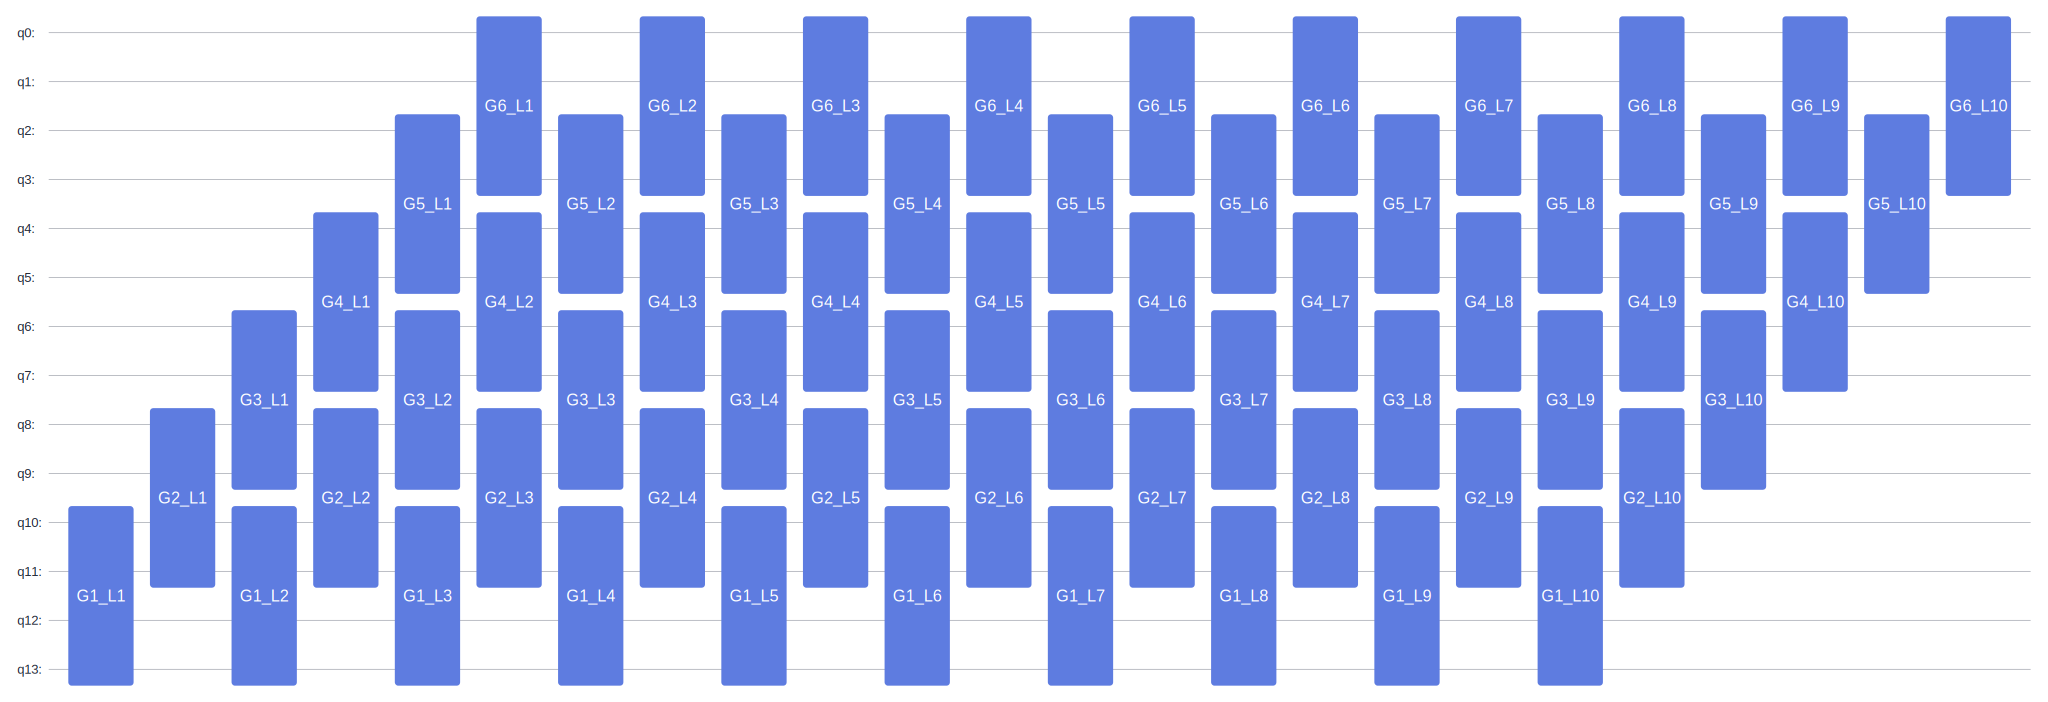

In [2]:
g = File('./mat/322_d3_num1_model957_RDM3_gates_L10_N7')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
f = g['fidelity'][0][0]  # fidelity of gates
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
# g.close()

r = File('./mat/322_d3_num1_model957_RDM_v7.3.mat')
l = list(r.keys())  # list of HDF5 rdm file keys
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

pr = {}
circ = Circuit()
ansatz = Circuit()
nq = (k + 1) * (d - 1)
Id = symmetric_encoding(np.eye(d**2), 2)
p = np.eye(Id.shape[0]) - Id
for i in range(len(g_name)):
    for j in range(k):
        name = f'G{j + 1}_L{i + 1}'
        mat = symmetric_encoding(gates[i][j], 2) + p
        obj = list(range(nq - (d - 1) * (j + 2), nq - (d - 1) * j))
        circ += UnivMathGate(name, mat).on(obj)

sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()

psi = symmetric_decoding(psi, k + 1)
rho_rdm = reduced_density_matrix(psi, d, position)
print('rho norm: %.20f' % norm(rdm[3] - rho_rdm, 2))
print('rho fidelity: %.20f' % fidelity(rdm[3], rho_rdm))

circ.svg()

Number of qubits: 9
Number of params: 1280
Number of gates: 1360
Hamiltonian Dimension: (512, 512)
rho norm: 0.00036726646838603475
rho fidelity: 0.99999936973640424220


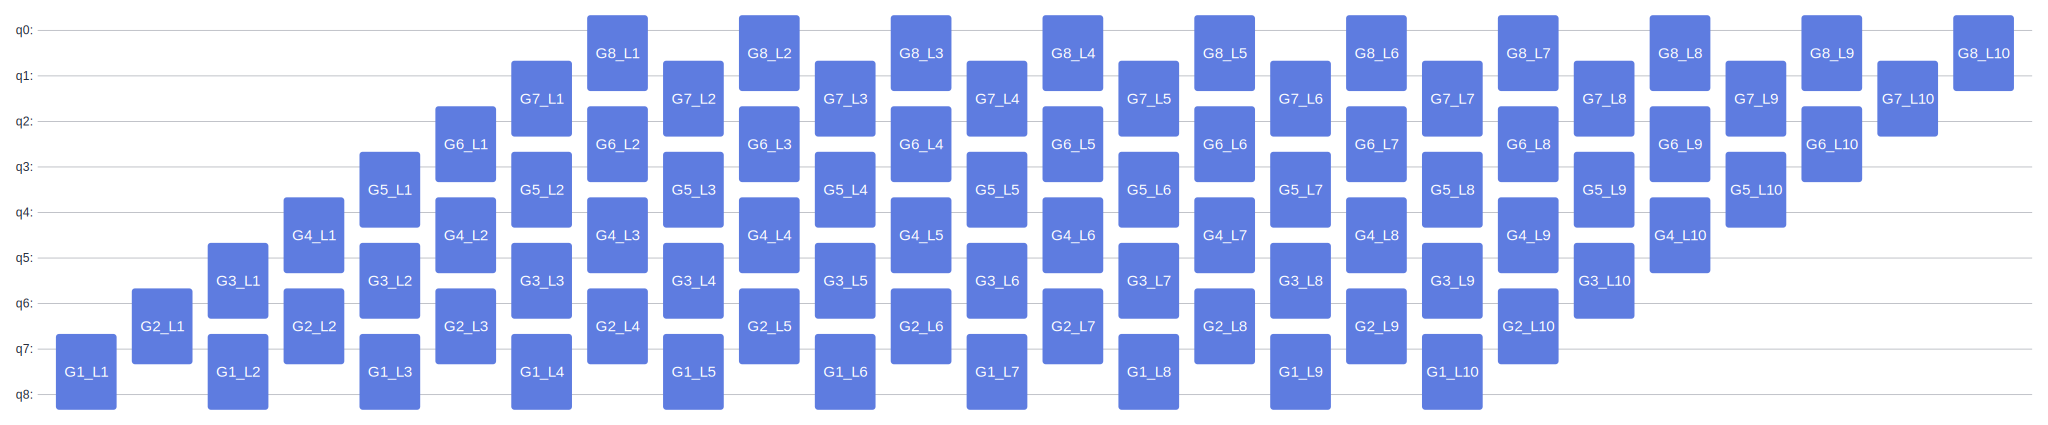

In [3]:
g = File('./mat/322_d2_num1_model957_RDM3_gates_L10_N9.mat')
position = g['RDM_site'][:] - 1  # subtract index of matlab to python
l = list(g.keys())  # list of HDF5 gates file keys
d = int(g['d'][0])  # dimension of qudit state
f = g['fidelity'][0][0]  # fidelity of gates
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d2_num1_model957_RDM_v7.3.mat')
l = list(r.keys())  # list of HDF5 rdm file keys
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

pr = {}
circ = Circuit()
ansatz = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        name = f'G{j + 1}_L{i + 1}'
        mat = gates[i][j]
        gate_u = UnivMathGate(name, mat).on([k - j - 1, k - j])
        gate_d, para = two_qubit_decompose(gate_u)
        pr.update(para)
        circ += gate_u
        ansatz += gate_d

nq = ansatz.n_qubits
p_name = ansatz.ansatz_params_name
pr = {i: pr[i] for i in p_name}
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()

rho = np.outer(psi, psi.conj())
print('Hamiltonian Dimension:', rho.shape)
Ham = Hamiltonian(csr_matrix(rho))

rho_rdm = reduced_density_matrix(psi, d, position)
print('rho norm: %.20f' % norm(rdm[3] - rho_rdm, 2))
print('rho fidelity: %.20f' % fidelity(rdm[3], rho_rdm))

circ.svg()

In [ ]:
g = File('./mat/322_d2_num1_model957_site3_gates_L39_N9_zhu(2).mat')
# position = g['position'][:] - 1  # subtract index of matlab to python
position = [3, 4, 5]
l = list(g.keys())  # list of HDF5 file keys
g_name = [x for x in l if 'gates' in x]  # list of Q_gates_?
key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
g_name = sorted(g_name, key=key)  # sort 1,10,11,...,2 into 1,2,...,10,11
# print(position, g_name)
k = g[g_name[0]].shape[0]  # number of gates in one layer
gates = [[g[g[i][j]][:].view('complex').T for j in range(k)] for i in g_name]
g.close()

r = File('./mat/322_d2_num1_model957_RDM_v7.3.mat')
l = list(r.keys())
rdm = [r[i][:].view('complex').T for i in l]
rdm.insert(0, [])
r.close()

In [ ]:
pr = {}
circ_u = Circuit()
circ_d = Circuit()
for i in range(len(g_name)):
    for j in range(k):
        gate_name = f'G{j + 1}_L{i + 1}'
        gate_mat = gates[i][j]
        if j == k - 1:
            gate_u = UnivMathGate(gate_name, gate_mat).on(k - j - 1)
            gate_d, para = one_qubit_decompose(gate_u)
            pr.update(para)
            circ_u += gate_u
            circ_d += gate_d
        else:
            gate_u = UnivMathGate(gate_name, gate_mat).on([k - j - 2, k - j - 1])
            gate_d, para = two_qubit_decompose(gate_u)
            pr.update(para)
            circ_u += gate_u
            circ_d += gate_d

circ_u.summary()
circ_d.summary()

sim_u = Simulator('mqvector', k)
sim_d = Simulator('mqvector', k)
sim_u.apply_circuit(circ_u)
sim_d.apply_circuit(circ_d.apply_value(pr))
psi_u = sim_u.get_qs()
psi_d = sim_d.get_qs()
rho_u = np.outer(psi_u, psi_u.conj())
rho_d = np.outer(psi_d, psi_d.conj())

print('circ norm: %.20f' % norm(circ_u.matrix() - circ_d.matrix(pr)))
print('psi norm: %.20f, fidelity: %.20f' % (norm(psi_u - psi_d, 2), fidelity(psi_u, psi_d)))
print('rho norm: %.20f, fidelity: %.20f' % (norm(rho_u - rho_d, 2), fidelity(rho_u, rho_d)))

rho = reduced_density_matrix(rho_u, position)
print('rdm[3] norm: %.20f, fidelity: %.20f' % (norm(rdm[3] - rho, 2), fidelity(rdm[3], rho)))

========Circuit Summary========
|Total number of gates  : 351.|
|Parameter gates        : 0.  |
|with 0 parameters are  :     |
|                        .    |
|Number qubit of circuit: 9   |
==========================================================================Circuit Summary==========================================================================
|Total number of gates   : 5460.                                                                                                                                  |
|Parameter gates         : 5460.                                                                                                                                  |
|with 5148 parameters are:                                                                                                                                        |
|G1_L1_B0_lam, G1_L1_B0_theta, G1_L1_B0_phi, G1_L1_B1_lam, G1_L1_B1_theta, G1_L1_B1_phi, G1_L1_Rxx, G1_L1_Ryy, G1_L1_Rzz, G1_L1_phase..                 

In [ ]:
ham = np.kron(np.kron(rdm[3], rdm[3]), rdm[3])
Ham = Hamiltonian(csr_matrix(ham))

ansatz = circ_d.apply_value(pr)
sim = Simulator('mqvector', ansatz.n_qubits)
sim.apply_circuit(ansatz)

print(sim.get_expectation(Ham, ansatz))
sim.get_expectation_with_grad(Ham, ansatz)

(0.3030279073981368+8.364951753784262e-17j)


True True
rho trace: 0.99999999999999400480
rho^2 trace: 0.76640206516669173720
0.9999990718069235 0.0004388447506908427


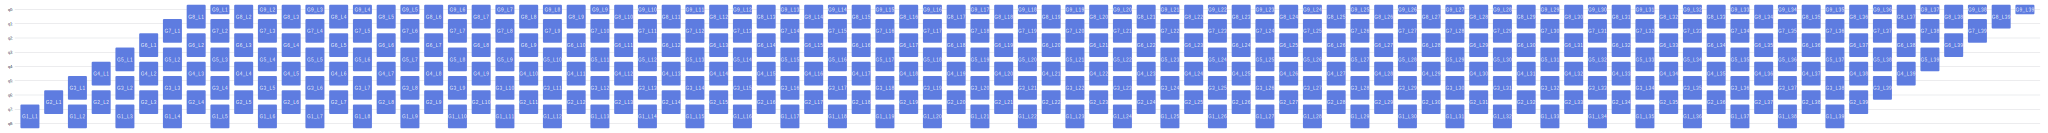

In [ ]:
circ = Circuit()
mat = np.eye(2**k)
for i in range(len(g_name)):
    for j in range(k):
        gate_name = f'G{j + 1}_L{i + 1}'
        gate_mat = gates[i][j]
        if j == k - 1:
            circ += UnivMathGate(gate_name, gate_mat).on(k - j - 1)
            temp = np.kron(np.eye(2**j), gate_mat)
        else:
            circ += UnivMathGate(gate_name, gate_mat).on([k - j - 2, k - j - 1])
            temp = np.kron(np.eye(2**j), np.kron(gate_mat, np.eye(2**(k - j - 2))))
        mat = mat @ temp.conj().T

sim = Simulator('mqvector', k)
psi0 = sim.get_qs()
sim.apply_circuit(circ)
psi = sim.get_qs()
rho = np.outer(psi, psi.conj())
print(np.allclose(psi, (psi0 @ mat).conj()), np.allclose(mat.conj().T, circ.matrix()))

rho = reduced_density_matrix(rho, position)
# # print(rho, rho.shape)
print('rho trace: %.20f' % np.real(np.trace(rho)))
print('rho^2 trace: %.20f' % np.real(np.trace(rho @ rho)))
print(fidelity(rdm[3], rho), norm(rdm[3] - rho, 2))

circ.svg()